In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# Separation prediction on general bodies

In this notebook, we will combine the vortex panel method and the boundary layer solver to predict separation on any 2D shape.

## Panel method and boundary layer coupling

What will we need to interface the `VortexPanel` and `BoundaryLayer` modules?  `VortexPanel` doesn't need anything from `BoundaryLayer` - it just needs a geometry and angle of attack.

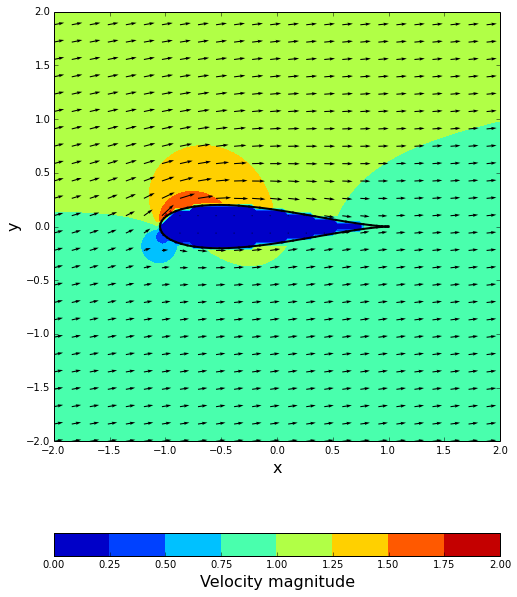

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from VortexPanel import solve_gamma_kutta,plot_flow,make_jukowski,make_circle

alpha = numpy.pi/20
N = 64
foil = make_jukowski(N)
solve_gamma_kutta(foil,alpha)
plot_flow(foil,alpha)

From the previous notebook we know the function `march` doesn't need the details of the geometry, but it does need:

- $s$: the distance along the boundary layer
- $u_e$: the velocity on the edge of the boundary layer
- $\nu$: the kinematic viscosity

We'll need to get the first two from the potential flow solution.

##### Quiz 1

What is the tangential velocity $u_e = \vec u\cdot\hat s$ on the fluid side of panel $p_i$?

1. $\left(\vec U +\sum_{j=0}^{N-1} \gamma_j \vec f_j(x_i,y_i)\right)\cdot \hat s_i$
1. $-\gamma_i$
1. $U_\infty$

Hint: Remember that we have set a boundary condition on the body side of the panel.

---
Next, let's get $s$. Note that a body will form **two** boundary layers, one on each side. We need to identify the starting point of these two flow regions.

##### Quiz 2

Where is the starting point of the two boundary layers?

1. The first and last panels: `foil[0]`, `foil[N-1]`
1. The panel where $u_e = 0$
1. The left-most panel, `foil[N/2]`

---

This makes it straightforward to split the body into the two boundary layer sections:

In [3]:
def split(panels):
    top = [p for p in panels if p.gamma<=0]
    bottom = [p for p in panels if p.gamma>=0]
    bottom = bottom[::-1]               # reverse array
    return top,bottom

In [4]:
foil_top,foil_bottom = split(foil)

Note that we changed the direction of the bottom array so that it runs from the stagnation point to the trailing edge, in accordance with the flow direction.

Lets plot them to make sure we got it right:

In [5]:
def plot_segment(panels):
    pyplot.figure(figsize=(10,2))
    pyplot.axis([-1.2,1.2,-.3,.3])
    for i,p_i in enumerate(panels): 
        p_i.plot()
        if i%10 == 0:
            pyplot.scatter(p_i.xc,p_i.yc)
            pyplot.text(p_i.xc,p_i.yc+0.05, 
                'panel ['+'%i'%i+']',fontsize=12)

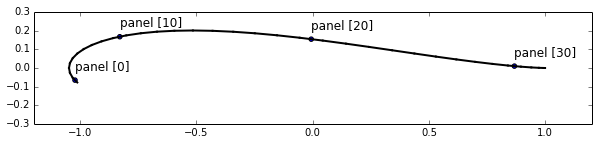

In [6]:
plot_segment(foil_top)

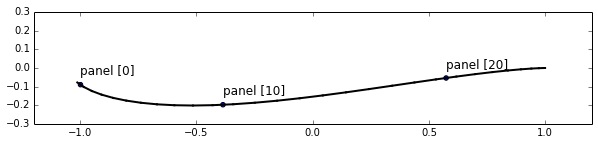

In [7]:
plot_segment(foil_bottom)

Looks good. 

Now that we've got it set up, the distance from the stagnation point along the boundary layer is found by iterative summation $s_{i+1} = s_i+S_i+S_{i+1}$, with $s_0 = S_0$.

In [8]:
def distance(panels):
    s = numpy.empty(len(panels))         
    s[0] = panels[0].S
    for i in range(len(s)-1):
        s[i+1] = s[i]+panels[i].S+panels[i+1].S
    return s

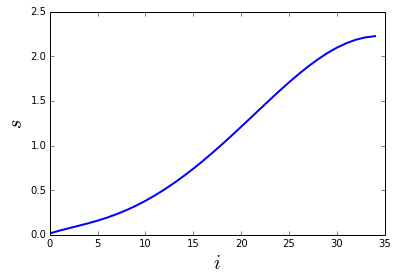

In [9]:
pyplot.xlabel(r"$i$",fontsize=20)
pyplot.ylabel(r"$s$",fontsize=20)
pyplot.plot(distance(foil_top),lw=2)

Notice that this line is curved because the panel width is **not** constant.

Finally, we'll put these together in a function `panel_march`, which grabs all the information we need from the panels and then runs `march`.

In [10]:
def panel_march(panels,nu):
    from BoundaryLayer import march
    s = distance(panels)                    # distance
    u_e = [abs(p.gamma) for p in panels]    # velocity
    return march(s,u_e,nu)                  # march

## Boundary layer around a circle

As our first application we will solve for the boundary layer on a circle. First we'll use the Vortex Panel code to set-up the geometry and solve for the potential flow. Then we'll split the `Panel` array and pass the top to the `panel_march` function.

In [11]:
circle = make_circle(N)                 # set-up circle
solve_gamma_kutta(circle)               # solve flow
top,bottom = split(circle)              # split panels
nu = 1e-5                               # set nu
delta,lam,iSep = panel_march(top,nu)    # march along top BL

##### Quiz 3

Why do I keep testing code on simple shapes like circles?

1. I'm terribly forgetful
1. New examples take work
1. I want to validate the new code

##### Numerical fundamental: Validation
##### Every piece of code must be tested against a known nontrivial example

---

So lets validate the results. The *theoretical* laminar separation point for a circular cylinder is $108\deg$ from the leading stagnation point. Since the circle has radius $R=1$, this corresponds to $s=1.88$. Lets check the simulation by plotting $\lambda$. 

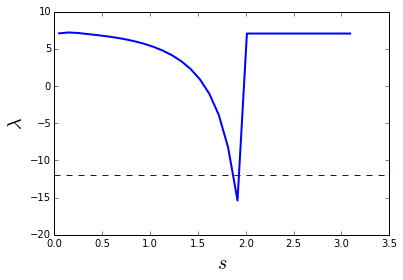

In [12]:
s = distance(top)
pyplot.ylabel(r'$\lambda$', fontsize=20)
pyplot.xlabel(r'$s$', fontsize=20)
pyplot.plot(s,lam,lw=2)
pyplot.axhline(-12,ls='--')

As you move along the boundary layer, $\lambda$ decreases from the initial stagnation point condition of $\lambda_0\approx7$ and eventually crosses the threshold for separation $\lambda=-12$. `march` stops once this condition is reached - **therefore the `lam` and `delta` arrays are meaningless after panel `iSep+1`**.

Let's define a function to interpolate the value of an array at the separation point:

In [13]:
# interpolate values at the separation point
def sep(y,lam,iSep): 
    return numpy.interp( 12,-lam[:iSep+2],y[:iSep+2])

Note that I only interpolate the array up until separation using `y[:iSep+2]`. This should also be used when plotting:

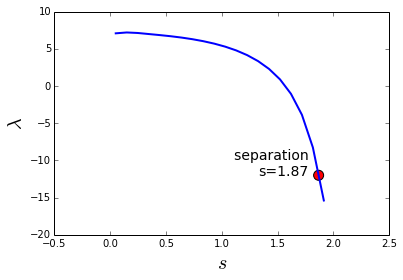

In [14]:
sSep = sep(s,lam,iSep)                 # find s @ separation
pyplot.ylabel(r'$\lambda$', fontsize=20)
pyplot.xlabel(r'$s$', fontsize=20)
pyplot.plot(s[:iSep+2],lam[:iSep+2],lw=2)
pyplot.scatter(sSep,-12, s=100, c='r')
pyplot.text(sSep-.1,-12,'separation \ns='+'%.2f' % sSep,
    fontsize=14,ha='right')

Our numerical method predicts separation at $s=1.87$ - less than a percent different than the theoretical result!

Now let's look at the boundary layer thickenss and compare it to the flat plate solution from the previous notebook

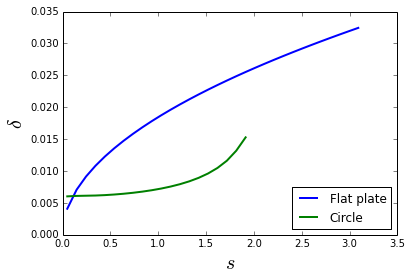

In [15]:
# plot the boundary layer thicknes and separation point
pyplot.ylabel(r'$\delta$', fontsize=20)
pyplot.xlabel(r'$s$', fontsize=20)
pyplot.plot(s,5.836*numpy.sqrt(nu*s),lw=2,label='Flat plate')
pyplot.plot(s[:iSep+2],delta[:iSep+2],lw=2,label='Circle')
pyplot.legend(loc='lower right')

Lets also plot the flow and separation points together.

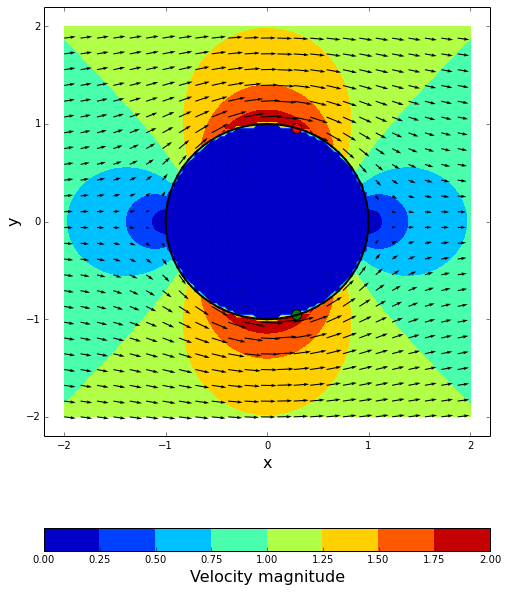

In [16]:
xSep = sep([p.xc for p in top],lam,iSep)
ySep = sep([p.yc for p in top],lam,iSep)

plot_flow(circle)
pyplot.scatter(xSep, ySep, s=100, c='r')
pyplot.scatter(xSep,-ySep, s=100, c='g')

The red and green dots mark the separation point for the top and bottom boundary layer, respectively.

It can't be over-emphasized how different the flat plate and circle boundary layers are. 

##### Fluid dynamic fundamental: 
##### Pressure gradients completely change the development of a boundary layer.

Because of these gradients:
 - The boundary layer growth is stunted on the front body
 - $\delta$ increases rapidly as the flow approaches the midbody
 - Separation occurs soon after the flow begins to decelerate. 

##### Quiz 4

How does the separation point depend on $\nu$?

1. Increasing $\nu$ delays separation
1. Decreasing $\nu$ delays separation
1. Chaning $\nu$ has no effect on separation

---

Is this a bug??

We know from lectures that $\delta$ scales as $\sqrt\nu$ (which you can double check using the code above), and therefore $\lambda=\frac{\delta^2}\nu u_e'$ doesn't depend on $\nu$ at all. Since the separation point is determined by $\lambda$, this is also independant of $\nu$.

##### Fluids fundamental: Separation Point
##### The point of laminar separation is independant of $Re$

This is **not** true of a turbulent boundary layer.

---

Now that we know the code is working, I've written a function to set-up, solve, and plot the separation points for a general set of panels.

In [17]:
from BoundaryLayer import solve_plot_separation
help(solve_plot_separation)

Help on function solve_plot_separation in module BoundaryLayer:

solve_plot_separation(panels, alpha=0)
    # solve for the external and BL flow and plot it



t/c = 0.197
Top separation at x/c = 0.200
Bottom separation at x/c = 0.763


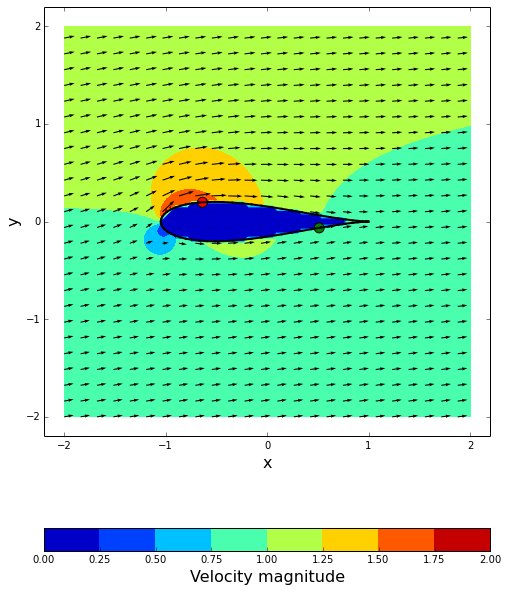

In [18]:
solve_plot_separation(foil,alpha)

And we see that at an angle of attack, the high pressure side of the foil (the bottom) has delayed separation, while the low pressure side has early separation. This is exactly the kind of information we need to predict stall.

---

Let's take a step back to appreciate what we've managed to do. By combining the `VortexPanel.solve_gamma_kutta` method with the Pohlhausen-based `BoundaryLayer.march` method, we've developed a numerical tool to predict separation on **any** body (or bodies) defined by a set of panels.

##### Numerical fundamental: Synergy
##### Simple functions can be linked to build powerful methods


## Aspect ratio validation

We've validated the code for the known case of a circle, but this is just one geometry. 

##### Numerical fundamental: Skepticism
##### `But that is what the computer said!' - Famous last words

We should validate a new method on as many known results as possible. 

One thing we could validate is that the separation points change properly if the aspect ratio $t/c$ is changed.  Here is a summary figure from Chapter 3 of Hoerner's *Fluid-Dynamic Drag*

---
![Hoerner Drag, Fig 5, Chap 3](resources/separation_hoerner.png)

---
There are four ellipse examples and two Jukowski examples. Based on this figure, I estimate:

Jukowski foil:

$t/c$| 0.17  | 0.15 
---|
$x/c$| $0.39$  | $0.49$ 

Ellipse:

$t/c$| 1 |1/2 | 1/4 | 1/6 | 1/8 
---|
$x/c$| $0.66$ | $0.75$ | $0.85$ | $0.89$ | $0.92$ 

where I've added the theoretical result for a circle.

##### Your turn #6

Validate the separation prediction method against these two families of geometries. 

 - **Predict** separation for the Jukowski cases, being sure to match $t/c$.
 - **Discuss** the results. Are these adequate to validate the numerical method? Are there any surprises?
 - **Plot** $x/c$ for the ellipse for `t_c=linspace(0.01,1)` compared to Hoerner's data. 
 - **Discuss** the results with regards to validation and trends.

##### Solution #6


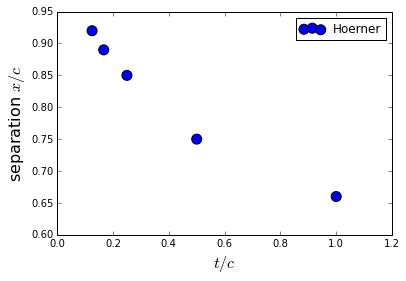

In [19]:
# your code here

pyplot.xlabel(r'$t/c$', fontsize=16)
pyplot.ylabel(r'separation $x/c$', fontsize=16)
pyplot.scatter([1,0.5,0.25,1./6,0.125],
               [0.66,0.75,0.85,0.89,0.92], 
               s=100, label='Hoerner')
pyplot.legend(loc='upper right')